In [1]:
#Install required library
!pip install -q tflite-model-maker

## **Import Libraries**

In [2]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

from sklearn.model_selection import train_test_split
import glob

In [3]:
# Specify de model to use
spec = model_spec.get('efficientdet_lite2')

## Dataset directory

In [4]:
#Directory for all the images
ImagesPath = "/content/drive/MyDrive/SoftwareEngineering/Images/"
#Directory for the labels
LabelsPath = "/content/drive/MyDrive/SoftwareEngineering/Labels/"

files = []
for file in glob.glob(ImagesPath+"*.jpg"):
    files.append(file[len(ImagesPath):-4])

937


## Split training, validation and test sets

In [5]:
train_filenames, validation_filenames = train_test_split(files, test_size = 0.2)
validation_filenames, test_filenames = train_test_split(validation_filenames, test_size = 0.2)


In [6]:
train_data = object_detector.DataLoader.from_pascal_voc(ImagesPath,LabelsPath,label_map={1: "RedRose"}, annotation_filenames=train_filenames)
validation_data = object_detector.DataLoader.from_pascal_voc(ImagesPath,LabelsPath,label_map={1: "RedRose"}, annotation_filenames=validation_filenames)
test_data = object_detector.DataLoader.from_pascal_voc(ImagesPath,LabelsPath,label_map={1: "RedRose"}, annotation_filenames=test_filenames)


## Train the model

In [7]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, train_whole_model=True, validation_data=validation_data, epochs = 50)

Epoch 1/5
93/93 [==============================] - 435s 4s/step - det_loss: 1.2064 - cls_loss: 0.7035 - box_loss: 0.0101 - reg_l2_loss: 0.0630 - loss: 1.2694 - learning_rate: 0.0090 - gradient_norm: 1.9702 - val_det_loss: 0.8816 - val_cls_loss: 0.5130 - val_box_loss: 0.0074 - val_reg_l2_loss: 0.0630 - val_loss: 0.9447
Epoch 2/5
93/93 [==============================] - 374s 4s/step - det_loss: 0.7353 - cls_loss: 0.3800 - box_loss: 0.0071 - reg_l2_loss: 0.0631 - loss: 0.7983 - learning_rate: 0.0069 - gradient_norm: 2.0323 - val_det_loss: 0.6491 - val_cls_loss: 0.3396 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0631 - val_loss: 0.7121
Epoch 3/5
93/93 [==============================] - 364s 4s/step - det_loss: 0.6480 - cls_loss: 0.3546 - box_loss: 0.0059 - reg_l2_loss: 0.0631 - loss: 0.7111 - learning_rate: 0.0031 - gradient_norm: 1.9760 - val_det_loss: 0.6187 - val_cls_loss: 0.3297 - val_box_loss: 0.0058 - val_reg_l2_loss: 0.0631 - val_loss: 0.6817
Epoch 4/5
93/93 [=======================

## Evaluate and export the model

In [8]:
# Evaluate the Tensorflow model
model.evaluate(test_data)

1/1 [==============================] - 10s 10s/step



{'AP': 0.41631028,
 'AP50': 0.84010524,
 'AP75': 0.3631322,
 'AP_/RedRose': 0.41631028,
 'APl': 0.4483286,
 'APm': 0.45962825,
 'APs': 0.3221728,
 'ARl': 0.5551282,
 'ARm': 0.5710526,
 'ARmax1': 0.10956938,
 'ARmax10': 0.4555024,
 'ARmax100': 0.55598086,
 'ARs': 0.53636366}

In [9]:
# Export the model in the same directory
model.export(export_dir='.')

In [10]:
# Evaluate the compressed Tensorflow Lite model
model.evaluate_tflite('model.tflite', test_data)

38/38 [==============================] - 100s 3s/step



{'AP': 0.41135874,
 'AP50': 0.8279452,
 'AP75': 0.34732464,
 'AP_/RedRose': 0.41135874,
 'APl': 0.4481208,
 'APm': 0.45146596,
 'APs': 0.32083133,
 'ARl': 0.5435898,
 'ARm': 0.5407895,
 'ARmax1': 0.1138756,
 'ARmax10': 0.45454547,
 'ARmax100': 0.52200955,
 'ARs': 0.46545455}

# Optional

## Functions to do the inference

In [11]:
import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
    classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
    """Preprocess the input image to feed to the TFLite model"""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    original_image = img
    resized_img = tf.image.resize(img, input_size)
    resized_img = resized_img[tf.newaxis, :]
    return resized_img, original_image


def set_input_tensor(interpreter, image):
    """Set the input tensor."""
    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
    """Returns the output tensor at the given index."""
    output_details = interpreter.get_output_details()[index]
    tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
    return tensor


def detect_objects(interpreter, image, threshold):
    """Returns a list of detection results, each a dictionary of object info."""
    # Feed the input image to the model
    set_input_tensor(interpreter, image)
    interpreter.invoke()

    # Get all outputs from the model
    boxes = get_output_tensor(interpreter, 1)
    classes = get_output_tensor(interpreter, 3)
    scores = get_output_tensor(interpreter, 0)
    count = int(get_output_tensor(interpreter, 2))
    
    results = []
    Nroses = 0
    for i in range(count):
        if scores[i] >= threshold:
            result = {
            'bounding_box': boxes[i],
            'class_id': classes[i],
            'score': scores[i]
            }
            results.append(result)
            Nroses+=1
    print('Number of Red Roses: ', Nroses)
    return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
    """Run object detection on the input image and draw the detection results"""
    # Load the input shape required by the model
    _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

    # Load the input image and preprocess it
    preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

    # Run object detection on the input image
    results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

    # Plot the detection results on the input image
    original_image_np = original_image.numpy().astype(np.uint8)
    for obj in results:
        # Convert the object bounding box from relative coordinates to absolute
        # coordinates based on the original image resolution
        ymin, xmin, ymax, xmax = obj['bounding_box']
        xmin = int(xmin * original_image_np.shape[1])
        xmax = int(xmax * original_image_np.shape[1])
        ymin = int(ymin * original_image_np.shape[0])
        ymax = int(ymax * original_image_np.shape[0])

        # Find the class index of the current object
        class_id = int(obj['class_id'])

        # Draw the bounding box and label on the image
        color = [int(c) for c in COLORS[class_id]]
        cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
        # Make adjustments to make the label visible for all objects
        y = ymin - 15 if ymin - 15 > 15 else ymin + 15
        label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
        cv2.putText(original_image_np, label, (xmin, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Return the final image
    original_uint8 = original_image_np.astype(np.uint8)
    return original_uint8

## Test the model in a Single Image

Number of Red Roses:  12


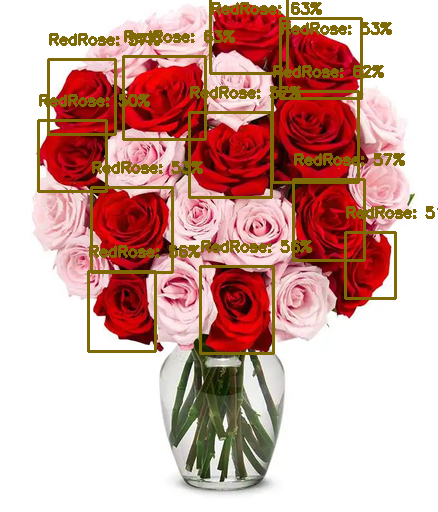

In [13]:
# Default Threshold = 0.5
DETECTION_THRESHOLD = 0.5

# Path for the input image
InputImagePath = 'rose5.jpg'

# Name for the Resized image that will be created and taken as input
InputImagePath2 = 'ResizedInputRoses.png'

im = Image.open(InputImagePath)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(InputImagePath2, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    InputImagePath2,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)